# Adaptive PDE discretizations on cartesian grids 
## Volume : Divergence form PDEs
## Part : Static problems
## Chapter : Elliptic equations

This notebook illustrates the use of non-negative finite difference schemes to solve elliptic partial differential equations (PDEs). More precisely, we look for a solution $u$ defined over a bounded domain $\Omega$ to the PDE
$$
    -\mathrm{div}(D\nabla u) + \alpha u = f,
$$
where $D$ is a field of positive definite matrices, and $\alpha$ is a non-negative scalar field. 
Dirichlet boundary conditions are applied on the boundary. We also consider Neumann boundary conditions which take the form
$$
    < n(x), D(x)\nabla u(x)> = 0
$$
for all points $x$ in a subset $\Gamma \subset\partial \Omega$ of the boundary.

**Energy minimization.** The above PDE can be rephrased as the optimality condition to an optimization problem, involving an elliptic energy. More precisely, the solution $u \in H^1(\Omega)$ to above PDE is also the unique minimizer to the energy
$$
     E(u) = \frac 1 2 \int_\Omega (\| \nabla u\|_{D}^2 + \alpha u^2) - \int_\Omega f u.
$$
Again, Dirichlet boundary conditions are imposed on the boundary. In this form, Neumann boundary conditions become to free boundary conditions (a.k.a. no constraint) on the corresponding part of the boundary.

**Variational form.** The equivalence of the PDE with the energy minimization is obtained by considering an arbitrary test function $v \in H^1_0(\Omega)$ (or  $v \in H^1(\Omega)$ for Neumann boundary conditions). Then (i) multiplying the PDE and integrating by parts, or (ii) considering that $E(u+\epsilon v) \geq E(u)$ for any $\epsilon$, one obtains the variational form
$$
    \int_\Omega <\nabla u,D \nabla v> + \alpha u v - f v = 0.
$$
The variational form is *not* used in this notebook, where we prefer the energetic formulation. It does appear in the next notebook.

**Note on the implementation of the boundary conditions.**
A cartesian grid of scale $h>0$ is used for discretization:
$$
    \Omega_h := \Omega \cap h Z^d.
$$
Because of the use of a cartesian grid, the implementation of the boundary conditions is rather crude, which limits the accuracy of the numerical solution. Ad-hoc techniques including changes of variables, domain decompositions, fictitious domains, etc ... may be used to improve the discretization of the boundary conditions. 

The proposed implementations, if not modified, should therefore be used in contexts where the boundary conditions only play a minor role, if e.g. the solution decays quickly, or where accurary is not the main concern, e.g. in image processing.

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic scheme](#1.-Isotropic-scheme)
  * [2. Naive anisotropic scheme](#2.-Naive-anisotropic-scheme)
  * [3. Anisotropic scheme](#3.-Anisotropic-scheme)
  * [4. Neuman boundary conditions](#4.-Neuman-boundary-conditions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('Elliptic','Div')

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
LInfNorm = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## 1. Isotropic scheme

We first consider a simplified problem in which the diffusion tensors are isotropic :
$$
    D = d \mathrm{Id}
$$
The optimization problem becomes
$$
    \frac 1 2 \int_\Omega ( d \| \nabla u\|^2 + \alpha u^2) -\int_\Omega f u.
$$
It is discretized using the scheme
$$
    \frac{h^d} 2 \sum_{x \in \Omega_h} (d(x) a_h(x) + \alpha(x) u(x)^2) 
    {-} h^d \sum_{x \in \Omega_h} f(x) u(x)
$$
where for each point $x \in \Omega_h$ of the discretization domain
$$
     a_h(x) := \frac 1 2 \sum_{i\in \{0,1\}} \sum_{\sigma\in \{-1,1\}} (\frac{u(x+\sigma h e_i)-u(x)} h)^2 
$$

In [4]:
def Scheme_Iso(u,diff,alpha,f,bc,h):
    """Isotropic elliptic energy, with Dirichlet boundary conditions"""
    hd = h**u.ndim # h^d scaling factor for integrals
    
    # Apply Dirichlet boundary conditions
    boundary = np.logical_not(np.isnan(bc))
    bc_integrand = (u-bc)**2
    bc_energy = bc_integrand[boundary].sum()*hd
    
    u=u.copy() # Avoid side effects.
    u[boundary] = bc[boundary]
      
    # Construct energy  
    offsets = np.stack( ((1,0), (0,1), (-1,0), (0,-1)), axis=-1)
    du = fd.DiffUpwind(u, offsets,h)
    integrand = 0.25*diff*(du**2).sum(axis=0)+0.5*alpha*u**2 - f*u
    
    ad.simplify_ad(integrand) # Recommended for performance
    energy = integrand.sum()*hd
    
    return energy + bc_energy

Our next step is to generate the parameters.

In [5]:
# Create the domain
gridScale = 0.02
aX0 = np.arange(-1,1,gridScale); aX1=aX0;
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan) 
bc[X0**2+X1**2>=0.9**2] = 1

# Choose the PDE parameters
diff = 1+0.8*X0
alpha = 1+0.8*X1
f = np.sin(4*(X0+X1))

We next evaluate the scheme on a variable which incorporates second order symbolic perturbation.

In [6]:
u = ad.Sparse2.identity(X0.shape)
energy = Scheme_Iso(u,diff,alpha,f,bc,gridScale)

Since the energy is quadratic, it can be minimized by solving a (symmetric positive definite) linear system, which amounts to a single Newton step.

In [7]:
solution = energy.solve_stationnary().reshape(u.shape)

In [8]:
solution2 = energy.solve_stationnary().reshape(u.shape)

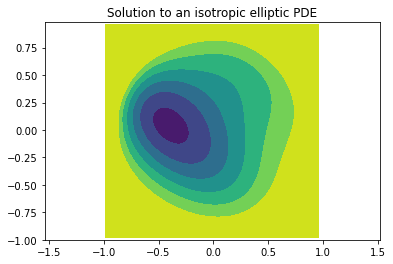

In [9]:
plt.axis('equal'); plt.title("Solution to an isotropic elliptic PDE")
plt.contourf(X0,X1,solution);

In order to check that the computed solution is correct, we consider a first order symbolic perturbation.

In [10]:
v = solution + ad.Sparse.identity(X0.shape)

In [11]:
energy = Scheme_Iso(v,diff,alpha,f,bc,gridScale)

We next evaluate the gradient of the energy w.r.t. a perturbation of the solution. As expected, this quantity vanishes over the domain.

In [12]:
gradient = energy.to_dense(u.size).coef.reshape(X0.shape)

In [13]:
LInfNorm(gradient)

nan

## 2. Naive anisotropic scheme

In this section, we present a naive numerical scheme for the addressed PDE. This scheme can be used for testing that a solution is correct, or for constructing synthetic solutions. However it is not recommended to use it to solve PDEs, in particular anisotropic ones, since fundamental properties such as the discrete maximum principle are lacking.

The idea underlying this scheme is to estimate the PDE residue
$$
    {-} \mathrm{div} (D \nabla u) + \alpha u - f
$$
using centered finite differences for the gradient and divergence, and a standard matrix vector multiplication for $D \nabla u$. A similar residue accounts for the boundary conditions.

In [14]:
def Scheme_Naive(u,Diff,alpha,f,bc,h):
    """Residue for an anisotropic elliptic equation, 
    with Dirichlet boundary conditions. (Naive implementation)"""
    
    # Residue of the PDE in the interior
    offsets = np.stack( ((1,0), (0,1)), axis=-1)
    du = fd.DiffCentered(u, offsets, h, padding=0)
    v = lp.dot_AV(Diff,du)
    div_v = fd.DiffCentered(v[0],(1,0),h) + fd.DiffCentered(v[1],(0,1),h)
    residue = - div_v + alpha*u - f
    
    # Apply boundary conditions
    return np.where(np.isnan(bc),residue,u-bc)

We use the same PDE parameters as before, except for the diffusion tensors which are now provided in matrix form.

In [15]:
Diff_Iso = diff*fd.as_field(np.eye(2),X0.shape)

In [16]:
residue = Scheme_Naive(solution,Diff_Iso,alpha,f,bc,gridScale)

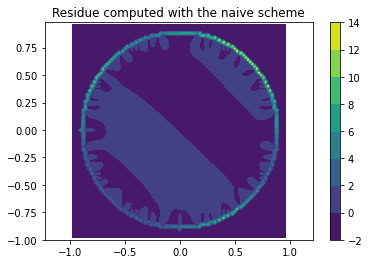

In [17]:
plt.axis('equal'); plt.title("Residue computed with the naive scheme")
plt.contourf(X0,X1,residue); plt.colorbar();

The residue is small in the interior, where the solution is smooth. 
It is larger, however, on the neighborhood of the boundary, due to lack of smoothness of the solution.
By construction, the residue vanishes exactly on the part of the domain where the Dirichlet boundary conditions are enforced.

In [18]:
LInfNorm(residue[X0**2+X1**2<0.7**2])

0.002600430292593825

One can try to solve the naive discretization as well. However the naive scheme here implemented is unstable, and high frequency oscillations are clearly visible in the resulting numerical solution.

In [19]:
u = ad.Sparse.identity(X0.shape)
residue = Scheme_Naive(u,Diff_Iso,alpha,f,bc,gridScale)

In [20]:
solution_naive = residue.solve()

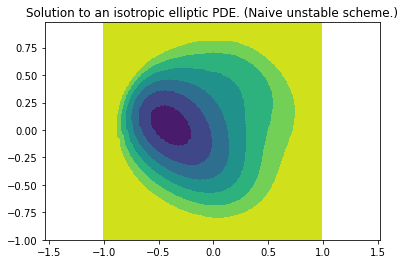

In [21]:
plt.axis('equal'); plt.title("Solution to an isotropic elliptic PDE. (Naive unstable scheme.)")
plt.contourf(X0,X1,solution_naive);

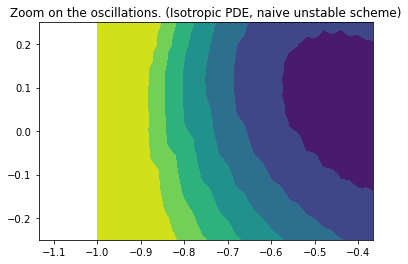

In [22]:
plt.axis('equal'); plt.title("Zoom on the oscillations. (Isotropic PDE, naive unstable scheme)")
plt.contourf(X0,X1,solution_naive); plt.xlim((-1.,-0.5)); plt.ylim((-0.25,0.25));

The problem only worsens if the diffusion tensors are anisotropic.

In [23]:
ev = np.stack((1.+0.*X0, np.sin(2*np.pi*X0)), axis=0)
evNorm = np.sqrt((ev**2).sum(axis=0))
ev /= evNorm
              
Diff = 0.4**2*lp.outer_self(ev) + lp.outer_self(lp.perp(ev))

In [24]:
u = ad.Sparse.identity(X0.shape)
residue = Scheme_Naive(u,Diff,alpha,f,bc,gridScale)

In [25]:
solution_naive = residue.solve()

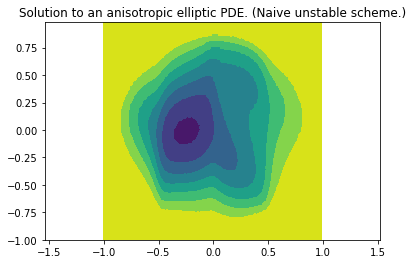

In [26]:
plt.axis('equal'); plt.title("Solution to an anisotropic elliptic PDE. (Naive unstable scheme.)")
plt.contourf(X0,X1,solution_naive);

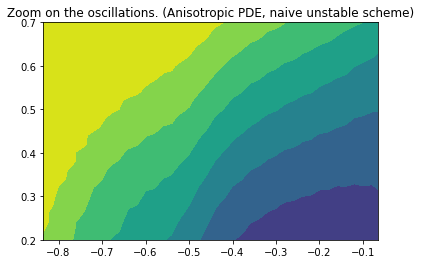

In [27]:
plt.axis('equal'); plt.title("Zoom on the oscillations. (Anisotropic PDE, naive unstable scheme)")
plt.contourf(X0,X1,solution_naive); plt.xlim((-0.7,-0.2)); plt.ylim((0.2,0.7));

## 3. Anisotropic scheme

In this section, we solve a general anisotropic elliptic PDE, using an adequate decomposition of the field $D$ of diffusion tensors.
Recall that the energy to be minimized reads
$$
     \frac 1 2 \int_\Omega (\| \nabla u\|_{D}^2 +  \alpha u^2) - \int_\Omega f u ,
$$
For that purpose, we rely on Selling's decomposition of the tensors, which reads
$$
    D(x) = \sum_{1 \leq i \leq I} \rho_i(x) e_i e_i^T,
$$
where the weights $\rho_i(x) \geq 0$ are non-negative, the offets $e_i \in Z^d$ have integer entries, and $I = d(d+1)/2$. The offsets actually depend on the point $x$, and adapt to the anisotropy directions of $D(x)$. See the notebook [TensorSelling](../Notebooks_Algo/TensorSelling.ipynb).

From this point, the discretization scheme is quite similar to the isotropic one
$$
    \frac {h^d} 2 \sum_{x \in \Omega_h} (a_h(x) + \alpha(x) u(x)^2) - h^d \sum_{x \in \Omega_h} f(x) u(x)
$$
where for each point $x \in \Omega_h$ of the discretization domain
$$
     a_h(x) := \frac 1 2 \sum_{1 \leq i \leq I} \sum_{\sigma\in \{-1,1\}} \rho_i(x) (\frac{u(x+\sigma h e_i)-u(x)} h)^2.
$$

In [28]:
def Scheme_Aniso(u,Diff,alpha,f,bc,h):
    """Anisotropic elliptic energy, with Dirichlet boundary conditions"""
    hd = h**u.ndim # h^d scaling factor for integrals

    # Apply Dirichlet boundary conditions
    boundary = np.logical_not(np.isnan(bc))
    bc_integrand = (u-bc)**2
    bc_energy = bc_integrand[boundary].sum()*hd
    
    u=u.copy() # Avoid side effects.
    u[boundary] = bc[boundary]
      
    # Decompose tensors
    coefs,offsets = Selling.Decomposition(Diff)
    coefs,offsets = np.concatenate((coefs,coefs),axis=0),np.concatenate((offsets,-offsets),axis=1)
    
    # Construct energy
    du = fd.DiffUpwind(u, offsets,h)
    integrand = 0.25*(coefs*du**2).sum(axis=0) +0.5*alpha*u**2 - f*u
    ad.simplify_ad(integrand)
    energy = integrand.sum()*hd
    
    return energy+bc_energy

Interestingly, the anisotropic scheme reduces to the original isotropic scheme if the tensors are isotropic. 
Indeed, Selling's decomposition of an isotropic or diagonal tensor only involves offsets from the canonical basis of $R^d$.

In [29]:
u = ad.Sparse2.identity(X0.shape)
energy = Scheme_Aniso(u,Diff_Iso,alpha,f,bc,gridScale)

In [30]:
solution = energy.solve_stationnary().reshape(u.shape)

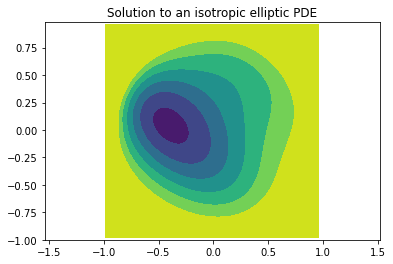

In [31]:
plt.axis('equal'); plt.title("Solution to an isotropic elliptic PDE")
plt.contourf(X0,X1,solution);

However, we can now reliably handle anisotropic tensors.

In [32]:
u = ad.Sparse2.identity(X0.shape)
energy = Scheme_Aniso(u,Diff,alpha,f,bc,gridScale)

In [33]:
solution = energy.solve_stationnary().reshape(u.shape)

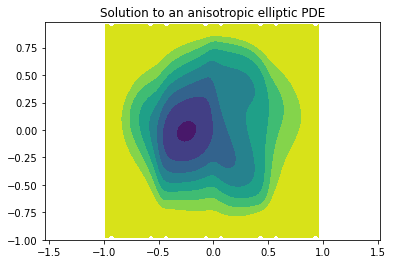

In [34]:
plt.axis('equal'); plt.title("Solution to an anisotropic elliptic PDE")
plt.contourf(X0,X1,solution);

In [35]:
residue = Scheme_Naive(solution,Diff,alpha,f,bc,gridScale)

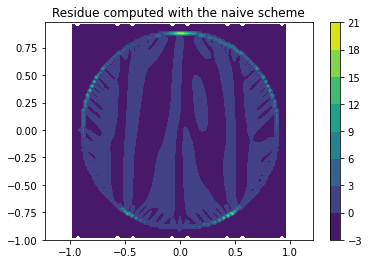

In [36]:
plt.axis('equal'); plt.title("Residue computed with the naive scheme")
plt.contourf(X0,X1,residue); plt.colorbar();

The residue is not so small, because the solution is not very smooth, and because of the treatment of the boundary conditions, but it decays as expected with the grid scale.

In [37]:
LInfNorm(residue[X0**2+X1**2<0.7**2])

0.24618908524915517

## 4. Neuman boundary conditions

We show how to implement Neumann boundary conditions on the left part of the domain. This property is encoded with the specific value $+\infty$ for the boundary conditions.

In [38]:
bc_Neumann = np.where(np.logical_or(X0<=0,np.isnan(bc)), bc, np.inf)

In [39]:
def Scheme_Aniso2(u,Diff,alpha,f,bc,h):
    """Anisotropic elliptic energy, with Dirichlet and Neumann boundary conditions"""
    hd = h**u.ndim # h^d scaling factor for integrals
    
    # Apply Dirichlet boundary conditions
    dir_mask = np.isfinite(bc)
    dir_integrand = (u-bc)**2
    dir_energy = dir_integrand[dir_mask].sum()*hd
    
    neu_mask = np.isinf(bc)
    neu_integrand = u**2
    neu_energy = neu_integrand[neu_mask].sum()*hd
    
    u=u.copy()
    u[dir_mask] = bc[dir_mask]
    u[neu_mask] = np.nan
    
    # Decompose tensors
    coefs,offsets = Selling.Decomposition(Diff)
    coefs,offsets = np.concatenate((coefs,coefs),axis=0),np.concatenate((offsets,-offsets),axis=1)
    
    # Construct energy
    du = fd.DiffUpwind(u, offsets,h)
    du[np.isnan(du)] = 0. 
    integrand = 0.25*(coefs*du**2).sum(axis=0) +0.5*alpha*u**2 - f*u
    
    ad.simplify_ad(integrand)
    energy = integrand[np.logical_not(neu_mask)].sum()*hd
        
    return energy+dir_energy+neu_energy

In [40]:
u = ad.Sparse2.identity(X0.shape)
energy = Scheme_Aniso2(u,Diff,alpha,f,bc_Neumann,gridScale)

In [41]:
solution = energy.solve_stationnary().reshape(u.shape)

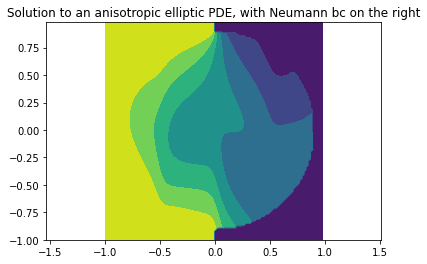

In [42]:
plt.axis('equal'); plt.title("Solution to an anisotropic elliptic PDE, with Neumann bc on the right")
plt.contourf(X0,X1,solution);